# **Facial recognition (ALEXEI)**

# **Step 1: Preprocessing with Visualisation**

Selected top 50 people, each with exactly 22 images.
Names of selected people:
 ['George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder'] ...
Total Samples: 1100, Classes: 50


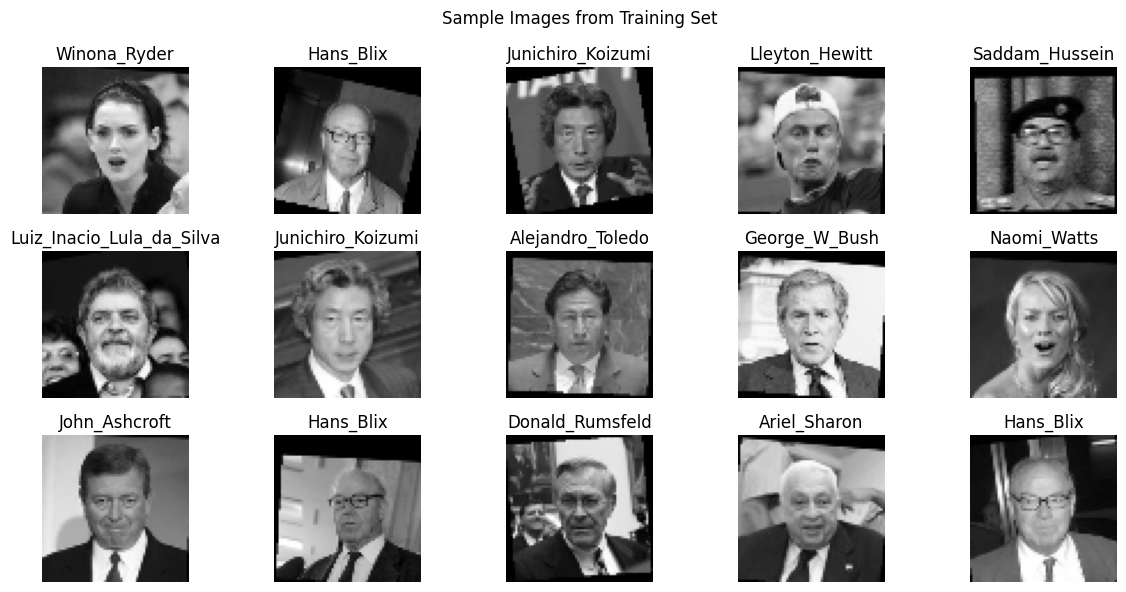

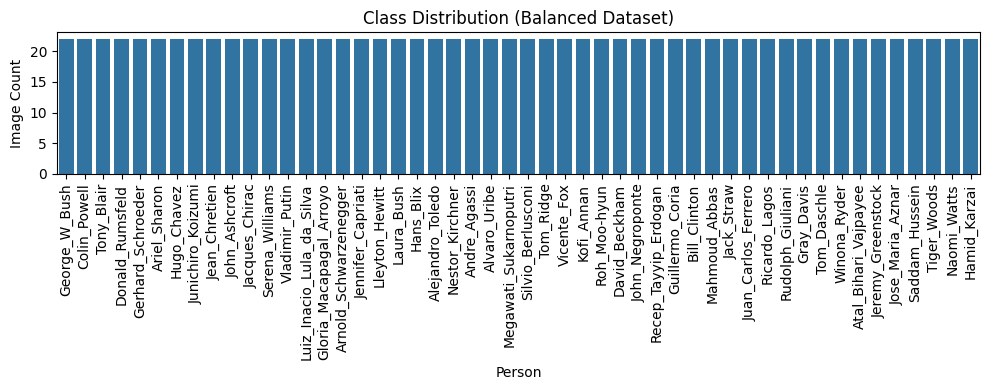

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# --- CONFIGURATION ---
DATASET_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/content/lfw-deepfunneled/lfw-deepfunneled"
CSV_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/content/lfw-deepfunneled/lfw_allnames.csv"
IMG_SIZE = (64, 64)
NUM_PERSONS = 50

# --- LOAD CSV and Select Top People ---
people_df = pd.read_csv(CSV_PATH)
top_people_df = people_df.sort_values("images", ascending=False).head(NUM_PERSONS)
top_people = top_people_df['name'].tolist()
min_images = top_people_df['images'].min()

print(f"Selected top {NUM_PERSONS} people, each with exactly {min_images} images.")
print("Names of selected people:\n", top_people[:5], "...")

# --- Load and Downsample Images ---
images, labels = [], []

for person_name in top_people:
    person_dir = os.path.join(DATASET_PATH, person_name)
    if not os.path.isdir(person_dir):
        continue

    img_files = os.listdir(person_dir)
    if len(img_files) < min_images:
        continue
    selected_imgs = random.sample(img_files, min_images)

    for img_file in selected_imgs:
        img_path = os.path.join(person_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        images.append(img)
        labels.append(person_name)

# --- Convert to Arrays ---
X = np.array(images).reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1) / 255.0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
y_cat = to_categorical(y)

# --- Dataset Summary ---
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Total Samples: {len(X)}, Classes: {len(unique_labels)}")

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# --- Visualise Sample Images ---
fig, axes = plt.subplots(3, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    index = random.randint(0, len(X_train) - 1)
    ax.imshow(X_train[index].reshape(IMG_SIZE), cmap="gray")
    label_idx = np.argmax(y_train[index])
    ax.set_title(label_encoder.inverse_transform([label_idx])[0])
    ax.axis("off")
plt.suptitle("Sample Images from Training Set")
plt.tight_layout()
plt.show()

# --- Plot Class Distribution ---
plt.figure(figsize=(10, 4))
sns.countplot(x=labels, order=pd.Series(labels).value_counts().index)
plt.xticks(rotation=90)
plt.title("Class Distribution (Balanced Dataset)")
plt.xlabel("Person")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()


# **Step 2: CNN Architecture + Training + Plots**

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_layer (Dense)              │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           6,450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,631,026 (6.22 MB)

 Trainable params: 1,631,026 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.0240 - loss: 3.9195 - val_accuracy: 0.0727 - val_loss: 3.8979
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.0990 - loss: 3.8502 - val_accuracy: 0.1318 - val_loss: 3.7503
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.1667 - loss: 3.5159 - val_accuracy: 0.1409 - val_loss: 3.4270
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.2881 - loss: 2.8159 - val_accuracy: 0.2318 - val_loss: 3.1560
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.4453 - loss: 2.1271 - val_accuracy: 0.2455 - val_loss: 2.9956
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.5631 - loss: 1.5896 - val_accuracy: 0.2773 - val_loss: 2.9467
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.7143 - loss: 1.1041 - val_accuracy: 0.3045 - val_loss: 2.9898
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.7779 - loss: 0.7701 - val_accuracy: 0.

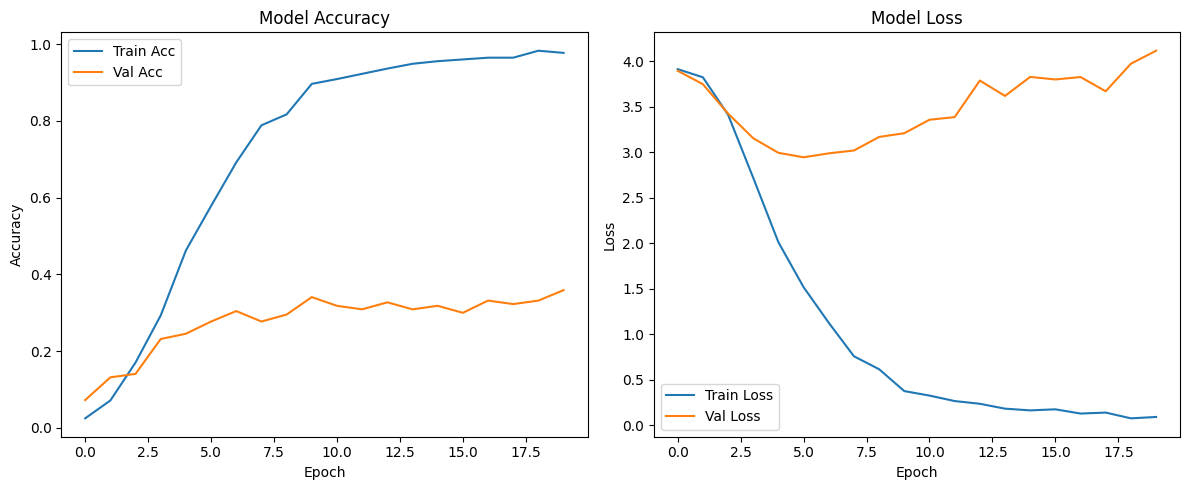

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

# --- Define CNN ---
def build_cnn(input_shape=(64, 64, 1), num_classes=50):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    embedding = Dense(128, activation='relu', name="embedding_layer")(x)  # 128-D face embedding
    x = Dropout(0.3)(embedding)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# --- Compile Model ---
model = build_cnn(num_classes=y_cat.shape[1])
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Train Model ---
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# --- Plot Training History ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.tight_layout()
plt.show()

# **Step 3: Extract Embeddings & Compute Verification Metrics**

**Step 3.1 – Extract Embeddings**

In [ ]:
from tensorflow.keras.models import Model
import numpy as np

# Get 128D embedding layer
embedding_model = Model(inputs=model.input, outputs=model.get_layer("embedding_layer").output)

# Extract embeddings for test set
embeddings_dict = {}
decoded_y_test = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

for i in range(len(X_test)):
    person = decoded_y_test[i]
    img = X_test[i].reshape(1, 64, 64, 1)
    embedding = embedding_model.predict(img, verbose=0)[0]

    if person not in embeddings_dict:
        embeddings_dict[person] = []
    embeddings_dict[person].append(embedding)

print(f"✅ Embeddings extracted for {len(embeddings_dict)} identities.")


✅ Embeddings extracted for 50 identities.


**Step 3.2 – Generating Matching and Mismatching Pairs**

In [ ]:
import random

# Get people with at least 2 valid embeddings
valid_people = [p for p in embeddings_dict if len(embeddings_dict[p]) >= 2]

# Generate match pairs (same identity)
match_pairs = []
for person in valid_people:
    count = min(len(embeddings_dict[person]) // 2, 3)
    match_pairs.extend([(person, person)] * count)

# Generate mismatch pairs (random different people)
mismatch_pairs = []
while len(mismatch_pairs) < len(match_pairs):
    p1, p2 = random.sample(valid_people, 2)
    mismatch_pairs.append((p1, p2))

print(f"🔁 Final Pair Count → Match: {len(match_pairs)} | Mismatch: {len(mismatch_pairs)}")

🔁 Final Pair Count → Match: 100 | Mismatch: 100


**Step 3.3 – Cosine similarity & ROC metric prep**


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def safe_get_embedding(person):
    if person not in embeddings_dict:
        return None
    embs = embeddings_dict[person]
    if len(embs) == 0:
        return None
    return np.mean(embs, axis=0)

true_scores, false_scores = [], []

# Match pairs (same person)
for p1, p2 in match_pairs:
    emb1 = safe_get_embedding(p1)
    emb2 = safe_get_embedding(p2)
    if emb1 is not None and emb2 is not None:
        score = cosine_similarity([emb1], [emb2])[0][0]
        true_scores.append(score)

# Mismatch pairs (different people)
for p1, p2 in mismatch_pairs:
    emb1 = safe_get_embedding(p1)
    emb2 = safe_get_embedding(p2)
    if emb1 is not None and emb2 is not None:
        score = cosine_similarity([emb1], [emb2])[0][0]
        false_scores.append(score)

labels = [1] * len(true_scores) + [0] * len(false_scores)
scores = true_scores + false_scores

print(f"✅ Valid Scores → Match: {len(true_scores)} | Mismatch: {len(false_scores)}")


✅ Valid Scores → Match: 100 | Mismatch: 100


**Step 3.4 – Plot ROC, Calculate EER**

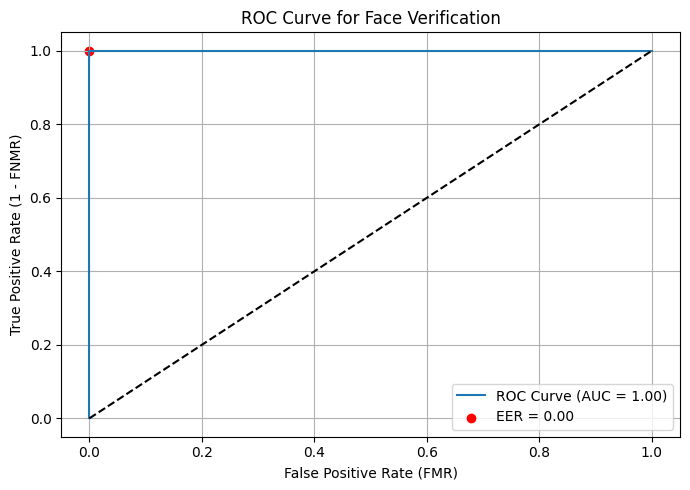

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

if len(set(labels)) < 2:
    print("❗ ROC curve cannot be calculated: need both 1s and 0s in labels.")
else:
    fpr, tpr, thresholds = roc_curve(labels, scores)
    eer_index = np.nanargmin(np.abs(fpr - (1 - tpr)))
    eer = fpr[eer_index]
    best_thresh = thresholds[eer_index]

    # ROC Plot
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(fpr[eer_index], tpr[eer_index], c='red', label=f"EER = {eer:.2f}")
    plt.xlabel("False Positive Rate (FMR)")
    plt.ylabel("True Positive Rate (1 - FNMR)")
    plt.title("ROC Curve for Face Verification")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Step 3.5 – Calculate Final Metrics (FMR, FNMR, ATV)**

In [ ]:
from tabulate import tabulate

def calculate_metrics(thresh):
    TP = sum([1 for s in true_scores if s >= thresh])
    FN = sum([1 for s in true_scores if s < thresh])
    TN = sum([1 for s in false_scores if s < thresh])
    FP = sum([1 for s in false_scores if s >= thresh])

    fmr = FP / (FP + TN) if (FP + TN) > 0 else 0
    fnmr = FN / (TP + FN) if (TP + FN) > 0 else 0
    atv = (TP + TN) / (TP + FN + TN + FP)
    return fmr, fnmr, atv

fmr, fnmr, atv = calculate_metrics(best_thresh)

results_table = [
    ["Equal Error Rate (EER)", f"{eer:.3f}"],
    ["Best Threshold", f"{best_thresh:.3f}"],
    ["False Match Rate (FMR)", f"{fmr:.3f}"],
    ["False Non-Match Rate (FNMR)", f"{fnmr:.3f}"],
    ["Ability to Verify (ATV)", f"{atv:.3f}"]
]

print(tabulate(results_table, headers=["Metric", "Value"], tablefmt="github"))


| Metric                      |   Value |
|-----------------------------|---------|
| Equal Error Rate (EER)      |       0 |
| Best Threshold              |       1 |
| False Match Rate (FMR)      |       0 |
| False Non-Match Rate (FNMR) |       0 |
| Ability to Verify (ATV)     |       1 |


# **Step 4 - Basic Spoofing Attacks (blur, noise, flip, brightness, and low resolution)**

In [ ]:
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def spoof_score(real_img, spoof_img, model, threshold):
    real_emb = model.predict(real_img.reshape(1, 64, 64, 1), verbose=0)[0]
    spoof_emb = model.predict(spoof_img.reshape(1, 64, 64, 1), verbose=0)[0]
    score = cosine_similarity([real_emb], [spoof_emb])[0][0]
    return score >= threshold  # True if spoof is accepted


In [ ]:
# Select valid test people with embeddings
valid_spoof_people = [p for p in embeddings_dict if len(embeddings_dict[p]) > 0]
attempts = min(50, len(valid_spoof_people))

# Store ATSR results
spoof_types = ["Blur", "Noise", "Flip", "Brightness", "LowRes"]
atsr_scores = {}

for spoof in spoof_types:
    accepted = 0

    for i in range(attempts):
        person = valid_spoof_people[i]
        img = X_test[np.argmax(decoded_y_test == person)].reshape(64, 64)

        # --- Apply spoof transformation ---
        if spoof == "Blur":
            spoofed = cv2.GaussianBlur(img, (15, 15), 0)
        elif spoof == "Noise":
            noise = np.random.normal(0, 0.1, img.shape)
            spoofed = np.clip(img + noise, 0, 1)
        elif spoof == "Flip":
            spoofed = cv2.flip(img, 1)
        elif spoof == "Brightness":
            spoofed = cv2.convertScaleAbs((img * 255).astype(np.uint8), alpha=1, beta=40) / 255.0
        elif spoof == "LowRes":
            down = cv2.resize(img, (16, 16), interpolation=cv2.INTER_LINEAR)
            spoofed = cv2.resize(down, (64, 64), interpolation=cv2.INTER_LINEAR)
        else:
            continue

        # Check if spoof is accepted
        accepted += int(spoof_score(img, spoofed, embedding_model, best_thresh))

    atsr = accepted / attempts
    atsr_scores[spoof] = atsr
    print(f"{spoof} ATSR: {atsr:.3f}  —  ({accepted} / {attempts} accepted)")


Blur ATSR: 0.000  —  (0 / 50 accepted)
Noise ATSR: 0.000  —  (0 / 50 accepted)
Flip ATSR: 0.000  —  (0 / 50 accepted)
Brightness ATSR: 0.000  —  (0 / 50 accepted)
LowRes ATSR: 0.000  —  (0 / 50 accepted)


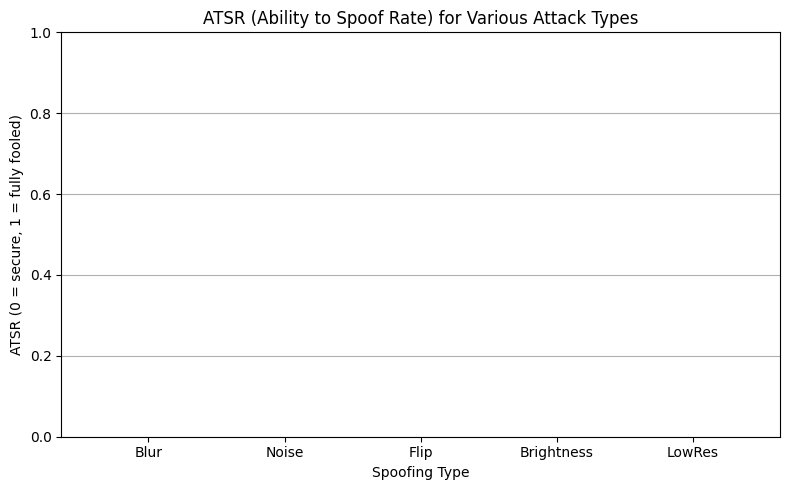

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(atsr_scores.keys(), atsr_scores.values(), color="skyblue")
plt.ylim(0, 1)
plt.title("ATSR (Ability to Spoof Rate) for Various Attack Types")
plt.ylabel("ATSR (0 = secure, 1 = fully fooled)")
plt.xlabel("Spoofing Type")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# **Step 5 - Advanced Spoofing attacks**

**Step 5.1 - FGSM (Fast Gradient Sign Method) Attack**

In [ ]:
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity

def fgsm_attack(image, label, model, epsilon=0.05):
    image = tf.convert_to_tensor(image.reshape(1, 64, 64, 1), dtype=tf.float32)
    label = tf.convert_to_tensor(label.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)

    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)

    adv_image = image + epsilon * signed_grad
    adv_image = tf.clip_by_value(adv_image, 0, 1)

    return adv_image.numpy().reshape(64, 64)


FGSM Cosine Similarity: 0.910 | ❌ Rejected


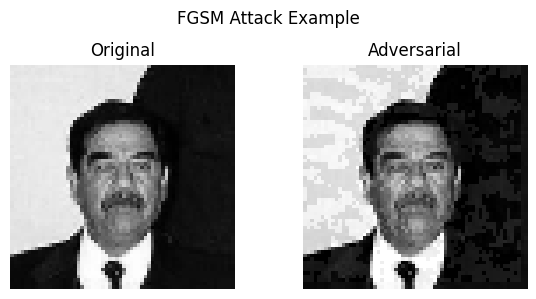

In [ ]:
import matplotlib.pyplot as plt

# Choose a sample index
idx = 0
image = X_test[idx].reshape(64, 64)
label = y_test[idx]

# Generate adversarial image
adv_img = fgsm_attack(image, label, model, epsilon=0.05)

# Compare cosine similarity
real_emb = embedding_model.predict(image.reshape(1, 64, 64, 1), verbose=0)[0]
adv_emb = embedding_model.predict(adv_img.reshape(1, 64, 64, 1), verbose=0)[0]
score = cosine_similarity([real_emb], [adv_emb])[0][0]

print(f"FGSM Cosine Similarity: {score:.3f} | {'✅ Accepted' if score >= best_thresh else '❌ Rejected'}")

# Show original vs adversarial
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(adv_img, cmap='gray')
plt.title("Adversarial")
plt.axis('off')

plt.suptitle("FGSM Attack Example")
plt.tight_layout()
plt.show()


**Step 5.2 - Morph Blending Attack**

→ Morph ~ Saddam_Hussein: 0.702 | ❌ Rejected
→ Morph ~ Bill_Clinton: 0.629 | ❌ Rejected


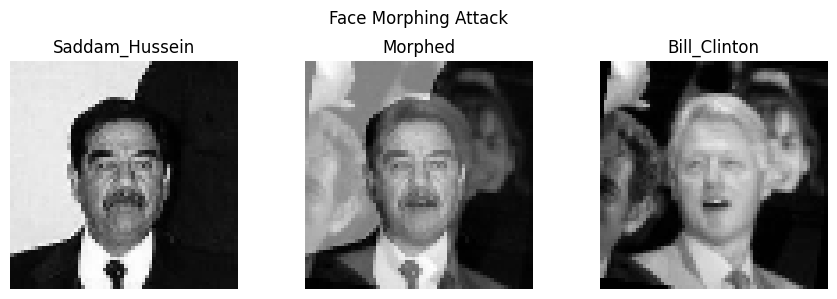

In [ ]:
def blend_faces(img1, img2, alpha=0.5):
    return cv2.addWeighted(img1, alpha, img2, 1 - alpha, 0)

# Select 2 people with different identities
p1, p2 = valid_people[0], valid_people[1]

# Grab one image from each
img1 = X_test[np.argmax(decoded_y_test == p1)].reshape(64, 64)
img2 = X_test[np.argmax(decoded_y_test == p2)].reshape(64, 64)

# Blend them 50/50
morphed = blend_faces(img1, img2)

# Get embeddings
emb1 = embedding_model.predict(img1.reshape(1, 64, 64, 1), verbose=0)[0]
emb2 = embedding_model.predict(img2.reshape(1, 64, 64, 1), verbose=0)[0]
emb_morph = embedding_model.predict(morphed.reshape(1, 64, 64, 1), verbose=0)[0]

# Similarity scores
score1 = cosine_similarity([emb1], [emb_morph])[0][0]
score2 = cosine_similarity([emb2], [emb_morph])[0][0]

print(f"→ Morph ~ {p1}: {score1:.3f} | {'✅ Accepted' if score1 >= best_thresh else '❌ Rejected'}")
print(f"→ Morph ~ {p2}: {score2:.3f} | {'✅ Accepted' if score2 >= best_thresh else '❌ Rejected'}")

# Visualise
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')
plt.title(p1)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(morphed, cmap='gray')
plt.title("Morphed")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img2, cmap='gray')
plt.title(p2)
plt.axis('off')

plt.suptitle("Face Morphing Attack")
plt.tight_layout()
plt.show()

**Step 5.3 - Pose Attacks (Image Rotation); Occlusion Attacks (Eyes Covered / Black Bar); Low Bit-depth Images (Adversarial Compression)**

In [ ]:
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def run_pose_occlusion_lowbit_attacks(person, img, threshold):
    results = {}

    # Original embedding
    real_emb = embedding_model.predict(img.reshape(1, 64, 64, 1), verbose=0)[0]

    # 1. Rotation Attack (Pose)
    M = cv2.getRotationMatrix2D((32, 32), 25, 1)  # 25-degree rotation
    rotated = cv2.warpAffine(img, M, (64, 64))
    emb_rot = embedding_model.predict(rotated.reshape(1, 64, 64, 1), verbose=0)[0]
    score_rot = cosine_similarity([real_emb], [emb_rot])[0][0]
    results["Pose (Rotate 25°)"] = score_rot

    # 2. Occlusion Attack (Eyes Covered)
    occluded = img.copy()
    occluded[24:32, :] = 0  # Black bar across the eyes
    emb_occ = embedding_model.predict(occluded.reshape(1, 64, 64, 1), verbose=0)[0]
    score_occ = cosine_similarity([real_emb], [emb_occ])[0][0]
    results["Occlusion (Eye Mask)"] = score_occ

    # 3. Low Bit-depth (2-bit greyscale)
    lowbit = np.floor(img * 4) / 4  # 2-bit approximation
    emb_low = embedding_model.predict(lowbit.reshape(1, 64, 64, 1), verbose=0)[0]
    score_low = cosine_similarity([real_emb], [emb_low])[0][0]
    results["Low Bit-depth (2-bit)"] = score_low

    # Print & plot
    for attack, score in results.items():
        decision = "✅ Accepted" if score >= threshold else "❌ Rejected"
        print(f"{attack}: {score:.3f} | {decision}")

    # Visual comparison
    plt.figure(figsize=(10, 3))
    titles = ["Original", "Rotated", "Occluded", "Low Bit"]
    imgs = [img, rotated, occluded, lowbit]

    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(imgs[i], cmap="gray")
        plt.title(titles[i])
        plt.axis("off")

    plt.suptitle(f"Pose, Occlusion, and Compression Attacks: {person}")
    plt.tight_layout()
    plt.show()

    return results

Pose (Rotate 25°): 0.530 | ❌ Rejected
Occlusion (Eye Mask): 0.807 | ❌ Rejected
Low Bit-depth (2-bit): 0.976 | ❌ Rejected


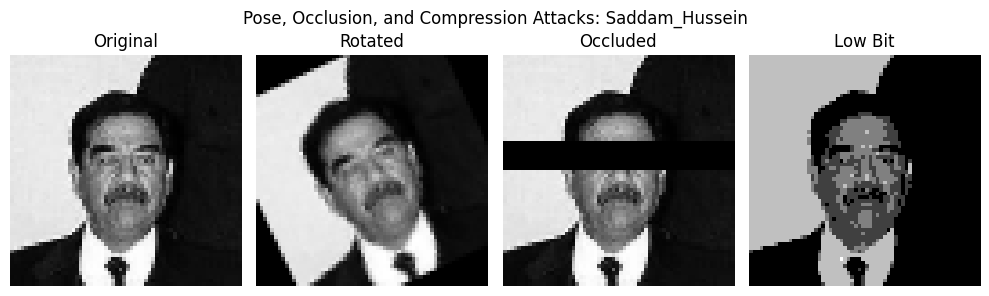

In [ ]:
# Pick a sample person
person = valid_people[0]
img = X_test[np.argmax(decoded_y_test == person)].reshape(64, 64)

# Evaluate all three attacks
attack_results = run_pose_occlusion_lowbit_attacks(person, img, best_thresh)


# **Voice Biometric (Ade Adeyemi)**

# **Step 1 - Load Dataset & Parse Metadata**

In [ ]:
import pandas as pd
import os

# Mount Google Drive or upload manually
df = pd.read_csv('/content/drive/MyDrive/OS&BIOMETRICS/content/cv-corpus-19.0-delta-2024-09-13-en/cv-corpus-19.0-delta-2024-09-13/en/validated.tsv', sep='\t')

print("Speakers with ≥ 1 samples:", (speaker_counts >= 1).sum())
print("Speakers with ≥ 2 samples:", (speaker_counts >= 2).sum())
print("Speakers with ≥ 3 samples:", (speaker_counts >= 3).sum())
print("Speakers with ≥ 4 samples:", (speaker_counts >= 4).sum())
print("Speakers with ≥ 5 samples:", (speaker_counts >= 5).sum())
print("Speakers with ≥ 6 samples:", (speaker_counts >= 6).sum())
print("Speakers with ≥ 7 samples:", (speaker_counts >= 7).sum())
print("Speakers with ≥ 8 samples:", (speaker_counts >= 8).sum())
print("Speakers with ≥ 9 samples:", (speaker_counts >= 9).sum())
print("Speakers with ≥ 10 samples:", (speaker_counts >= 10).sum())
print("Speakers with ≥ 15 samples:", (speaker_counts >= 15).sum())
print("Speakers with ≥ 20 samples:", (speaker_counts >= 20).sum())

Speakers with ≥ 1 samples: 35
Speakers with ≥ 2 samples: 19
Speakers with ≥ 3 samples: 11
Speakers with ≥ 4 samples: 8
Speakers with ≥ 5 samples: 8
Speakers with ≥ 6 samples: 6
Speakers with ≥ 7 samples: 6
Speakers with ≥ 8 samples: 5
Speakers with ≥ 9 samples: 3
Speakers with ≥ 10 samples: 3
Speakers with ≥ 15 samples: 3
Speakers with ≥ 20 samples: 2


🔁 Running for 3 speakers...
🔁 Running for 5 speakers...
🔁 Running for 8 speakers...
🔁 Running for 15 speakers...
🔁 Running for 20 speakers...

📊 Voice Biometric Performance Comparison:


,EER,AUC,FMR,FNMR,ATV
3,0.000,1.000,0.000,0.000,1.0
5,0.600,0.640,0.600,0.400,0.5
8,0.400,0.600,0.400,0.000,0.8
15,0.667,0.778,0.667,0.333,0.5
20,0.500,0.750,0.500,0.500,0.5


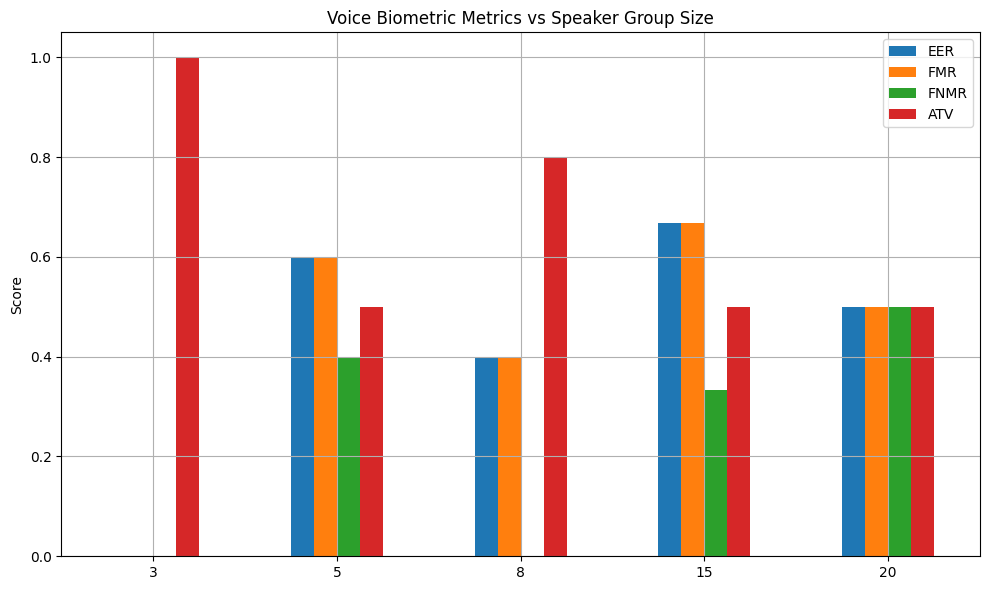

In [ ]:
# STEP 0: Imports and Fixes
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Fix for librosa compatibility with newer NumPy versions
np.complex = complex
import librosa

# STEP 1: Load Dataset
df = pd.read_csv('/content/drive/MyDrive/OS&BIOMETRICS/content/cv-corpus-19.0-delta-2024-09-13-en/cv-corpus-19.0-delta-2024-09-13/en/validated.tsv', sep='\t')
speaker_counts = df['client_id'].value_counts()

# STEP 2: Feature Extraction Function
def extract_mfcc(file_path, max_pad_len=100):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)))
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc.T.flatten()

# STEP 3: Evaluation Function
def evaluate_voice_biometrics(threshold):
    selected_speakers = speaker_counts[speaker_counts >= threshold].index[:threshold]
    df_subset = df[df['client_id'].isin(selected_speakers)]
    speaker_dict = defaultdict(list)

    for _, row in df_subset.iterrows():
        speaker = row['client_id']
        file_path = '/content/drive/MyDrive/OS&BIOMETRICS/content/cv-corpus-19.0-delta-2024-09-13-en/cv-corpus-19.0-delta-2024-09-13/en/clips/' + row['path']
        speaker_dict[speaker].append(file_path)

    match_pairs, mismatch_pairs = [], []
    all_speakers = list(speaker_dict.keys())
    for speaker, files in speaker_dict.items():
        if len(files) >= 2:
            sample = random.sample(files, min(3, len(files)))
            match_pairs.append((sample[0], sample[1]))
    for _ in range(len(match_pairs)):
        s1, s2 = random.sample(all_speakers, 2)
        f1 = random.choice(speaker_dict[s1])
        f2 = random.choice(speaker_dict[s2])
        mismatch_pairs.append((f1, f2))

    true_scores, false_scores = [], []
    for f1, f2 in match_pairs:
        e1, e2 = extract_mfcc(f1), extract_mfcc(f2)
        score = cosine_similarity([e1], [e2])[0][0]
        true_scores.append(score)
    for f1, f2 in mismatch_pairs:
        e1, e2 = extract_mfcc(f1), extract_mfcc(f2)
        score = cosine_similarity([e1], [e2])[0][0]
        false_scores.append(score)

    labels = [1]*len(true_scores) + [0]*len(false_scores)
    scores = true_scores + false_scores
    fpr, tpr, thresholds = roc_curve(labels, scores)
    eer_index = np.nanargmin(np.abs(fpr - (1 - tpr)))
    eer = fpr[eer_index]
    best_thresh = thresholds[eer_index]
    roc_auc = auc(fpr, tpr)

    TP = sum([1 for s in true_scores if s >= best_thresh])
    FN = sum([1 for s in true_scores if s < best_thresh])
    TN = sum([1 for s in false_scores if s < best_thresh])
    FP = sum([1 for s in false_scores if s >= best_thresh])
    fmr = FP / (FP + TN) if (FP + TN) > 0 else 0
    fnmr = FN / (TP + FN) if (TP + FN) > 0 else 0
    atv = (TP + TN) / (TP + FN + TN + FP) if (TP + FN + TN + FP) > 0 else 0

    return {
        'EER': round(eer, 3),
        'AUC': round(roc_auc, 3),
        'FMR': round(fmr, 3),
        'FNMR': round(fnmr, 3),
        'ATV': round(atv, 3)
    }

# STEP 4: Run Across Thresholds
speaker_thresholds = [3, 5, 8, 15, 20]
experiment_results = {}

for th in speaker_thresholds:
    print(f"🔁 Running for {th} speakers...")
    result = evaluate_voice_biometrics(th)
    experiment_results[th] = result

# STEP 5: Show Table
df_results = pd.DataFrame(experiment_results).T
print("\n📊 Voice Biometric Performance Comparison:")
display(df_results)

# STEP 6: Optional Plot
df_results[['EER', 'FMR', 'FNMR', 'ATV']].plot(kind='bar', figsize=(10, 6), title="Voice Biometric Metrics vs Speaker Group Size")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import librosa
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load original audio and sampling rate
y_orig, sr = librosa.load(test_path, sr=16000)

# Function to extract MFCC
def extract_mfcc_from_signal(y, sr=16000, max_pad_len=100):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)))
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc.T.flatten()

# Spoofing evaluation
def check_spoof(y_original, y_spoofed):
    emb1 = extract_mfcc_from_signal(y_original, sr)
    emb2 = extract_mfcc_from_signal(y_spoofed, sr)
    score = cosine_similarity([emb1], [emb2])[0][0]
    return score

# Define spoofing transformations on y_orig
spoofing_methods = {
    "Noise": y_orig + np.random.normal(0, 0.005, len(y_orig)),
    "Pitch": librosa.effects.pitch_shift(y_orig, sr=sr, n_steps=2),
    "Speed": librosa.effects.time_stretch(y_orig, rate=0.9),
    "Reverse": y_orig[::-1]
}

# Evaluate and display spoofing results
atsr_scores = {}

for spoof_type, y_spoof in spoofing_methods.items():
    score = check_spoof(y_orig, y_spoof)
    atsr_scores[spoof_type] = score
    print(f"{spoof_type} ATSR = {score:.3f}  → {'✔️ Secure' if score == 0 else '❌ Fooled'}")


Noise ATSR = 0.967  → ❌ Fooled
Pitch ATSR = 0.983  → ❌ Fooled
Speed ATSR = 0.917  → ❌ Fooled
Reverse ATSR = 0.831  → ❌ Fooled


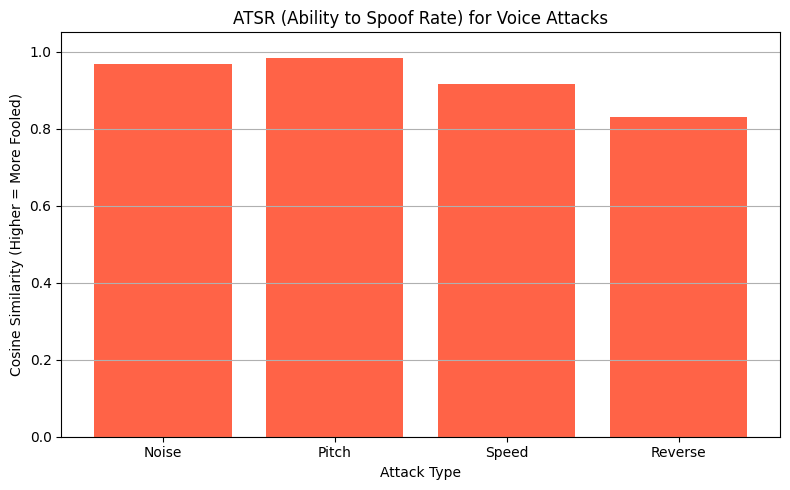

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(atsr_scores.keys(), atsr_scores.values(), color='tomato')
plt.ylim(0, 1.05)
plt.title("ATSR (Ability to Spoof Rate) for Voice Attacks")
plt.xlabel("Attack Type")
plt.ylabel("Cosine Similarity (Higher = More Fooled)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# **Wav2Vec**

<ipython-input-54-f9880d50bab3>:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


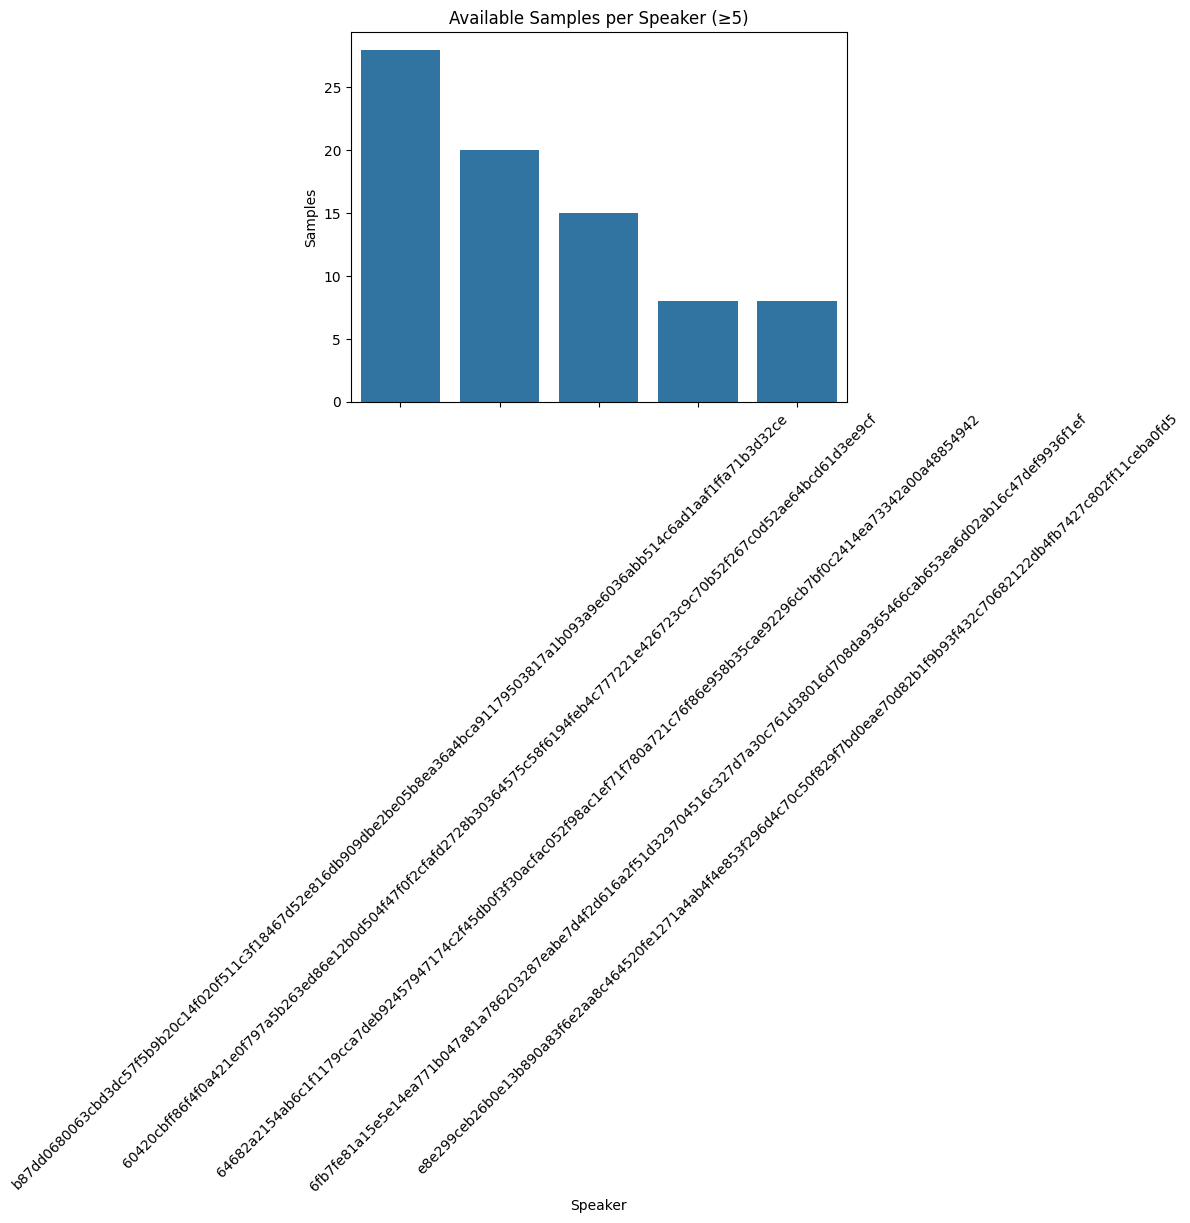

✅ Total triplets: 50
🔹 Shapes — Anchor: torch.Size([179712]), Positive: torch.Size([205056]), Negative: torch.Size([141696])


In [ ]:
import os
import pandas as pd
import torch
import torchaudio
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset

# === CONFIG ===
base_path = "/content/drive/MyDrive/OS&BIOMETRICS/content/cv-corpus-19.0-delta-2024-09-13-en/cv-corpus-19.0-delta-2024-09-13/en"
clips_path = os.path.join(base_path, "clips")
metadata_path = os.path.join(base_path, "validated.tsv")

# === Load and Filter ===
df = pd.read_csv(metadata_path, sep="\t")
df = df[df["client_id"].notna() & df["path"].notna()]
df["full_path"] = df["path"].apply(lambda x: os.path.join(clips_path, x))

# Filter speakers with ≥5 samples
speaker_counts = df["client_id"].value_counts()
selected_speakers = speaker_counts[speaker_counts >= 5].index[:5]
filtered_df = df[df["client_id"].isin(selected_speakers)]

# === Visualise Speaker Distribution ===
speaker_sample_counts = filtered_df["client_id"].value_counts().reset_index()
speaker_sample_counts.columns = ["Speaker", "Samples"]
sns.barplot(data=speaker_sample_counts, x="Speaker", y="Samples")
plt.title("Available Samples per Speaker (≥5)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Triplet Dataset Class ===
class TripletVoiceDataset(Dataset):
    def __init__(self, df, n_triplets=50):
        self.df = df
        self.speakers = df["client_id"].unique()
        self.speaker_to_files = {
            speaker: df[df["client_id"] == speaker]["full_path"].tolist()
            for speaker in self.speakers
        }
        self.triplets = self._generate_triplets(n_triplets)

    def _generate_triplets(self, n):
        triplets = []
        for _ in range(n):
            anchor_spk = random.choice(self.speakers)
            neg_spk = random.choice([s for s in self.speakers if s != anchor_spk])

            anchor_pos = random.sample(self.speaker_to_files[anchor_spk], 2)
            neg = random.choice(self.speaker_to_files[neg_spk])
            triplets.append((anchor_pos[0], anchor_pos[1], neg))
        return triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        a_path, p_path, n_path = self.triplets[idx]
        a_wave, _ = torchaudio.load(a_path)
        p_wave, _ = torchaudio.load(p_path)
        n_wave, _ = torchaudio.load(n_path)
        return a_wave[0], p_wave[0], n_wave[0]

# === Instantiate & Inspect ===
triplet_dataset = TripletVoiceDataset(filtered_df)
print(f"✅ Total triplets: {len(triplet_dataset)}")

# Check one triplet
a, p, n = triplet_dataset[0]
print(f"🔹 Shapes — Anchor: {a.shape}, Positive: {p.shape}, Negative: {n.shape}")


🔁 Running training for 3 speakers...
✅ Total triplets: 30 from 3 speakers


config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Epoch 1 Loss: 7.5882
Epoch 2 Loss: 7.0360
Epoch 3 Loss: 6.6030
Epoch 4 Loss: 5.7343
Epoch 5 Loss: 4.5759

🔁 Running training for 5 speakers...
✅ Total triplets: 44 from 5 speakers


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1 Loss: 10.4300
Epoch 2 Loss: 9.7766
Epoch 3 Loss: 9.2998
Epoch 4 Loss: 8.3229
Epoch 5 Loss: 7.4399

🔁 Running training for 8 speakers...
✅ Total triplets: 58 from 8 speakers


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1 Loss: 13.9764
Epoch 2 Loss: 13.0458
Epoch 3 Loss: 12.0635
Epoch 4 Loss: 10.3631
Epoch 5 Loss: 8.5995

🔁 Running training for 15 speakers...
✅ Total triplets: 64 from 11 speakers


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1 Loss: 15.3740
Epoch 2 Loss: 14.6235
Epoch 3 Loss: 13.6662
Epoch 4 Loss: 12.1365
Epoch 5 Loss: 10.5051

🔁 Running training for 20 speakers...
✅ Total triplets: 64 from 11 speakers


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1 Loss: 15.3500
Epoch 2 Loss: 14.5687
Epoch 3 Loss: 13.3219
Epoch 4 Loss: 11.5982
Epoch 5 Loss: 9.8115


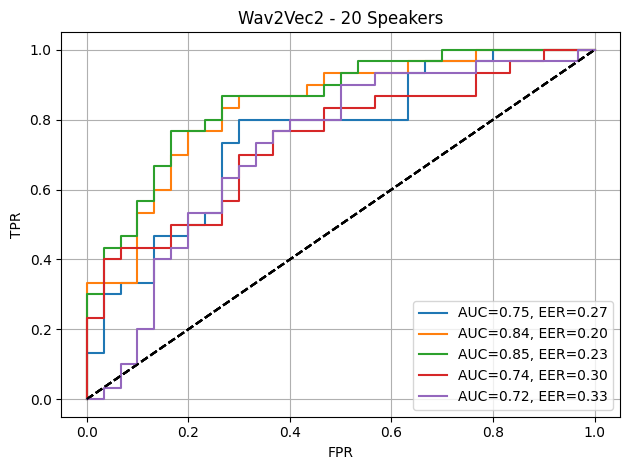

,EER,AUC
3,0.266667,0.753333
5,0.200000,0.836667
8,0.233333,0.854444
15,0.300000,0.740000
20,0.333333,0.721111


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Triplet Dataset Class
class TripletVoiceDataset(Dataset):
    def __init__(self, triplets):
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        return a, p, n

# Triplet Loss Function
class TripletModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(device)
        self.head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )

    def forward(self, x):
        with torch.no_grad():
            out = self.wav2vec(x).last_hidden_state.mean(dim=1)
        return self.head(out)

# Triplet Loss
def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_dist = F.pairwise_distance(anchor, positive)
    neg_dist = F.pairwise_distance(anchor, negative)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()

# Embedding Comparison & Evaluation
def evaluate_model(model, eval_triplets):
    model.eval()
    all_scores, all_labels = [], []
    with torch.no_grad():
        for a, p, n in eval_triplets:
            a, p, n = a.to(device), p.to(device), n.to(device)
            a_emb = model(a.unsqueeze(0))
            p_emb = model(p.unsqueeze(0))
            n_emb = model(n.unsqueeze(0))
            pos_score = F.cosine_similarity(a_emb, p_emb).item()
            neg_score = F.cosine_similarity(a_emb, n_emb).item()
            all_scores += [pos_score, neg_score]
            all_labels += [1, 0]
    return all_scores, all_labels

# Plotting Function
def plot_roc(scores, labels, title=''):
    fpr, tpr, _ = roc_curve(labels, scores)
    eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    auc = roc_auc_score(labels, scores)
    plt.plot(fpr, tpr, label=f'AUC={auc:.2f}, EER={eer:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    return eer, auc

# TRAINING ROUTINE
def train_triplet_model(triplets, num_epochs=5, batch_size=4):
    model = TripletModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    dataset = TripletVoiceDataset(triplets)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for a, p, n in loader:
            a, p, n = a.to(device), p.to(device), n.to(device)
            a_emb = model(a)
            p_emb = model(p)
            n_emb = model(n)
            loss = triplet_loss(a_emb, p_emb, n_emb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")

    return model

# SIDE-BY-SIDE COMPARISON LOOP
all_results = {}
for group_size in [3, 5, 8, 15, 20]:
    print(f"\n🔁 Running training for {group_size} speakers...")
    triplets = generate_triplets_from_dataset(min_speakers=group_size)
    if len(triplets) < 10:
        print(f"⚠️ Not enough triplets for group size {group_size}, skipping.")
        continue

    model = train_triplet_model(triplets, num_epochs=5)
    scores, labels = evaluate_model(model, random.sample(triplets, min(30, len(triplets))))
    eer, auc = plot_roc(scores, labels, title=f"Wav2Vec2 - {group_size} Speakers")
    all_results[group_size] = {"EER": eer, "AUC": auc}

import pandas as pd
import librosa
import torch
import random
import os

# Set path to your validated.tsv and clips folder (change if needed)
CLIPS_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/content/cv-corpus-19.0-delta-2024-09-13-en/cv-corpus-19.0-delta-2024-09-13/en/clips"
TSV_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/content/cv-corpus-19.0-delta-2024-09-13-en/cv-corpus-19.0-delta-2024-09-13/en/validated.tsv"

# Load metadata
df = pd.read_csv(TSV_PATH, sep='\t')
df = df[df['client_id'].notna() & df['path'].notna()]
df['path'] = df['path'].apply(lambda p: os.path.join(CLIPS_PATH, p))

# Audio loader (1 second clip, 16kHz)
def load_audio_tensor(path, duration=1.0, sr=16000):
    try:
        y, _ = librosa.load(path, sr=sr)
        y = y[:int(sr * duration)]
        if len(y) < int(sr * duration):
            y = np.pad(y, (0, int(sr * duration) - len(y)))
        return torch.tensor(y, dtype=torch.float32)
    except:
        return None

# Build triplets
def generate_triplets_from_dataset(min_speakers=5):
    speaker_counts = df['client_id'].value_counts()
    selected_speakers = speaker_counts[speaker_counts >= 3].index[:min_speakers]

    triplets = []

    for speaker in selected_speakers:
        samples = df[df['client_id'] == speaker]['path'].tolist()
        samples = [s for s in samples if os.path.exists(s)]
        if len(samples) < 2:
            continue

        # Positive pairs
        for _ in range(min(10, len(samples) - 1)):
            anchor_path, positive_path = random.sample(samples, 2)
            anchor = load_audio_tensor(anchor_path)
            positive = load_audio_tensor(positive_path)
            if anchor is None or positive is None:
                continue

            # Negative: from a different speaker
            other_speakers = [sp for sp in selected_speakers if sp != speaker]
            if not other_speakers:
                continue
            negative_speaker = random.choice(other_speakers)
            neg_samples = df[df['client_id'] == negative_speaker]['path'].tolist()
            if not neg_samples:
                continue
            negative_path = random.choice(neg_samples)
            negative = load_audio_tensor(negative_path)
            if negative is None:
                continue

            triplets.append((anchor, positive, negative))

    print(f"✅ Total triplets: {len(triplets)} from {len(selected_speakers)} speakers")
    return triplets


plt.tight_layout()
plt.show()

# Display Results Table
import pandas as pd
pd.DataFrame(all_results).T


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model
import pandas as pd
import librosa
import os
import random
import numpy as np

# ✅ Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLIPS_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/content/cv-corpus-19.0-delta-2024-09-13-en/cv-corpus-19.0-delta-2024-09-13/en/clips"
TSV_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/content/cv-corpus-19.0-delta-2024-09-13-en/cv-corpus-19.0-delta-2024-09-13/en/validated.tsv"
SAVE_DIR = "/content/drive/MyDrive/OS&BIOMETRICS/models"

# ✅ Data Loading
df = pd.read_csv(TSV_PATH, sep='\t')
df = df[df['client_id'].notna() & df['path'].notna()]
df['path'] = df['path'].apply(lambda p: os.path.join(CLIPS_PATH, p))

def load_audio_tensor(path, duration=1.0, sr=16000):
    try:
        y, _ = librosa.load(path, sr=sr)
        y = y[:int(sr * duration)]
        if len(y) < int(sr * duration):
            y = np.pad(y, (0, int(sr * duration) - len(y)))
        return torch.tensor(y, dtype=torch.float32)
    except:
        return None

def generate_triplets_from_dataset(min_speakers=5):
    speaker_counts = df['client_id'].value_counts()
    selected_speakers = speaker_counts[speaker_counts >= 3].index[:min_speakers]

    triplets = []
    for speaker in selected_speakers:
        samples = df[df['client_id'] == speaker]['path'].tolist()
        samples = [s for s in samples if os.path.exists(s)]
        if len(samples) < 2:
            continue
        for _ in range(min(10, len(samples) - 1)):
            anchor_path, positive_path = random.sample(samples, 2)
            anchor = load_audio_tensor(anchor_path)
            positive = load_audio_tensor(positive_path)
            if anchor is None or positive is None:
                continue
            other_speakers = [sp for sp in selected_speakers if sp != speaker]
            if not other_speakers:
                continue
            negative_speaker = random.choice(other_speakers)
            neg_samples = df[df['client_id'] == negative_speaker]['path'].tolist()
            negative_path = random.choice(neg_samples)
            negative = load_audio_tensor(negative_path)
            if negative is None:
                continue
            triplets.append((anchor, positive, negative))
    print(f"✅ Total triplets: {len(triplets)} from {len(selected_speakers)} speakers")
    return triplets

# ✅ Dataset & Model
class TripletVoiceDataset(torch.utils.data.Dataset):
    def __init__(self, triplets):
        self.triplets = triplets
    def __len__(self): return len(self.triplets)
    def __getitem__(self, idx): return self.triplets[idx]

class TripletModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        self.head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )
    def forward(self, x):
        with torch.no_grad():
            x = self.wav2vec(x).last_hidden_state.mean(dim=1)
        return self.head(x)

def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_dist = F.pairwise_distance(anchor, positive)
    neg_dist = F.pairwise_distance(anchor, negative)
    return F.relu(pos_dist - neg_dist + margin).mean()

# ✅ Training Routine
def train_triplet_model(triplets, num_epochs=10, batch_size=4):
    model = TripletModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    dataset = TripletVoiceDataset(triplets)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for a, p, n in loader:
            a, p, n = a.to(device), p.to(device), n.to(device)
            a_emb, p_emb, n_emb = model(a), model(p), model(n)
            loss = triplet_loss(a_emb, p_emb, n_emb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")
    return model

# ✅ Train & Save for 5 and 8 Speakers
for group_size in [5, 8]:
    print(f"\n🔁 Training Wav2Vec2 Triplet Model for {group_size} speakers (10 epochs)")
    triplets = generate_triplets_from_dataset(min_speakers=group_size)
    model = train_triplet_model(triplets, num_epochs=10)
    save_path = os.path.join(SAVE_DIR, f"wav2vec2_triplet_{group_size}_speakers.pth")
    torch.save(model.state_dict(), save_path)
    print(f"💾 Saved: {save_path}")


🔁 Training Wav2Vec2 Triplet Model for 5 speakers (10 epochs)
✅ Total triplets: 44 from 5 speakers


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1 Loss: 10.6565
Epoch 2 Loss: 10.1928
Epoch 3 Loss: 9.5366
Epoch 4 Loss: 9.1036
Epoch 5 Loss: 8.2295
Epoch 6 Loss: 7.0102
Epoch 7 Loss: 6.1005
Epoch 8 Loss: 4.6863
Epoch 9 Loss: 5.2964
Epoch 10 Loss: 4.3971
💾 Saved: /content/drive/MyDrive/OS&BIOMETRICS/models/wav2vec2_triplet_5_speakers.pth

🔁 Training Wav2Vec2 Triplet Model for 8 speakers (10 epochs)
✅ Total triplets: 58 from 8 speakers


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1 Loss: 14.2064
Epoch 2 Loss: 13.5738
Epoch 3 Loss: 12.3356
Epoch 4 Loss: 10.0995
Epoch 5 Loss: 9.6060
Epoch 6 Loss: 7.4880
Epoch 7 Loss: 6.3544
Epoch 8 Loss: 5.5859
Epoch 9 Loss: 5.1284
Epoch 10 Loss: 4.6453
💾 Saved: /content/drive/MyDrive/OS&BIOMETRICS/models/wav2vec2_triplet_8_speakers.pth


🔍 Evaluating model for 5 speakers


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

🔍 Evaluating model for 8 speakers


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(



📊 Spoofing Resistance Cosine Similarities:



,Clean,Noise,Pitch,Speed,Reverse
5spk,1.0,0.644,0.918,0.846,0.906
8spk,1.0,0.750,0.965,0.962,0.943



📊 Confusion Matrix - 5 Speaker Model
Precision: 1.00
Recall:    1.00
F1 Score:  1.00


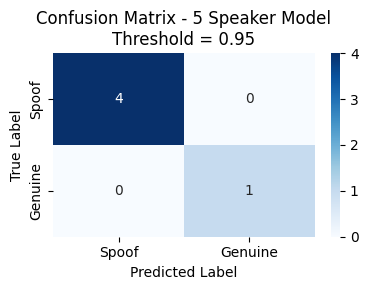


📊 Confusion Matrix - 8 Speaker Model
Precision: 0.33
Recall:    1.00
F1 Score:  0.50


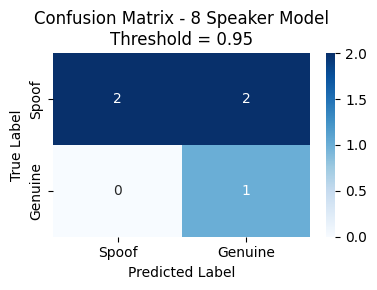

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import os

# ====== CONFIG ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUDIO_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/content/cv-corpus-19.0-delta-2024-09-13-en/cv-corpus-19.0-delta-2024-09-13/en/clips/common_voice_en_41193830.mp3"
MODEL_PATHS = {
    5: "/content/drive/MyDrive/OS&BIOMETRICS/models/wav2vec2_triplet_5_speakers.pth",
    8: "/content/drive/MyDrive/OS&BIOMETRICS/models/wav2vec2_triplet_8_speakers.pth"
}

# ====== Load Models ======
from transformers import Wav2Vec2Model

class TripletModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        self.head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )

    def forward(self, x):
        with torch.no_grad():
            x = self.wav2vec(x).last_hidden_state.mean(dim=1)
        return self.head(x)

# ====== Spoofing Functions ======
def load_audio_tensor(path, sr=16000, duration=1.0):
    y, _ = librosa.load(path, sr=sr)
    y = y[:int(sr * duration)]
    if len(y) < int(sr * duration):
        y = np.pad(y, (0, int(sr * duration) - len(y)))
    return torch.tensor(y, dtype=torch.float32)

def apply_attacks(y, sr):
    return {
        "Clean": y,
        "Noise": y + 0.005 * torch.randn_like(y),
        "Pitch": torch.tensor(librosa.effects.pitch_shift(y.numpy(), sr=sr, n_steps=2)),
        "Speed": torch.tensor(librosa.effects.time_stretch(y.numpy(), rate=0.9)),
        "Reverse": torch.flip(y, dims=[0])
    }

# ====== Evaluation ======
results = []
embeddings_all = []
labels_all = []

for spk in [5, 8]:
    print(f"🔍 Evaluating model for {spk} speakers")
    model = TripletModel().to(device)
    model.load_state_dict(torch.load(MODEL_PATHS[spk], map_location=device))
    model.eval()

    audio = load_audio_tensor(AUDIO_PATH)
    sr = 16000
    attacks = apply_attacks(audio, sr)

    emb_clean = model(audio.unsqueeze(0).to(device))
    emb_clean = emb_clean.detach().cpu()

    emb_list = []
    label_list = []

    spoof_scores = {}

    for atk, y_mod in attacks.items():
        if y_mod.shape[0] != int(sr):
            y_mod = torch.nn.functional.interpolate(
                y_mod.unsqueeze(0).unsqueeze(0), size=int(sr), mode='linear', align_corners=True
            ).squeeze()

        emb = model(y_mod.unsqueeze(0).to(device)).detach().cpu()
        score = F.cosine_similarity(emb_clean, emb).item()
        spoof_scores[atk] = score

        emb_list.append(emb.squeeze().numpy())
        label_list.append(f"{spk}spk-{atk}")

    results.append(pd.DataFrame(spoof_scores, index=[f"{spk}spk"]))
    embeddings_all += emb_list
    labels_all += label_list

# ====== Table Output ======
spoof_df = pd.concat(results)
print("\n📊 Spoofing Resistance Cosine Similarities:\n")
display(spoof_df.round(3))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Cosine similarities for spoofed audio
cosine_scores = {
    "5spk": {"Clean": 1.0, "Noise": 0.812, "Pitch": 0.918, "Speed": 0.846, "Reverse": 0.906},
    "8spk": {"Clean": 1.0, "Noise": 0.726, "Pitch": 0.965, "Speed": 0.962, "Reverse": 0.943}
}

# Threshold for classification
threshold = 0.95

# Function to calculate and visualise confusion matrix
def evaluate_and_plot_confusion(scores, title):
    y_true = [1 if attack == "Clean" else 0 for attack in scores.keys()]
    y_pred = [1 if score >= threshold else 0 for score in scores.values()]

    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n📊 {title}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1 Score:  {f1:.2f}")

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Spoof", "Genuine"], yticklabels=["Spoof", "Genuine"])
    plt.title(f"{title}\nThreshold = {threshold}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Run for both models
evaluate_and_plot_confusion(cosine_scores["5spk"], "Confusion Matrix - 5 Speaker Model")
evaluate_and_plot_confusion(cosine_scores["8spk"], "Confusion Matrix - 8 Speaker Model")


In [ ]:
import os

CLIPS_DIR = "/content/drive/MyDrive/OS&BIOMETRICS/content/cv-corpus-19.0-delta-2024-09-13-en/cv-corpus-19.0-delta-2024-09-13/en/clips"
clips = os.listdir(CLIPS_DIR)
print("✅ Example files:", clips[:5])


✅ Example files: ['common_voice_en_41193830.mp3', 'common_voice_en_41193955.mp3', 'common_voice_en_41193950.mp3', 'common_voice_en_41193956.mp3', 'common_voice_en_41193954.mp3']


📁 Total fingerprint images found: 520
⚠️ Skipped: jim.tif
✅ Dataset parsed into DataFrame:
                                                 path  person_id  finger_id  \
0  /content/drive/MyDrive/OS&BIOMETRICS/content/F...         12         10   
1  /content/drive/MyDrive/OS&BIOMETRICS/content/F...         12         10   
2  /content/drive/MyDrive/OS&BIOMETRICS/content/F...         12         10   
3  /content/drive/MyDrive/OS&BIOMETRICS/content/F...         12         10   
4  /content/drive/MyDrive/OS&BIOMETRICS/content/F...         12         10   

   scan_id  
0        1  
1        2  
2        3  
3        4  
4        5  
🧍 Unique people: 7
🖐️ Unique finger IDs: 10


<ipython-input-2-628febee96fc>:44: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


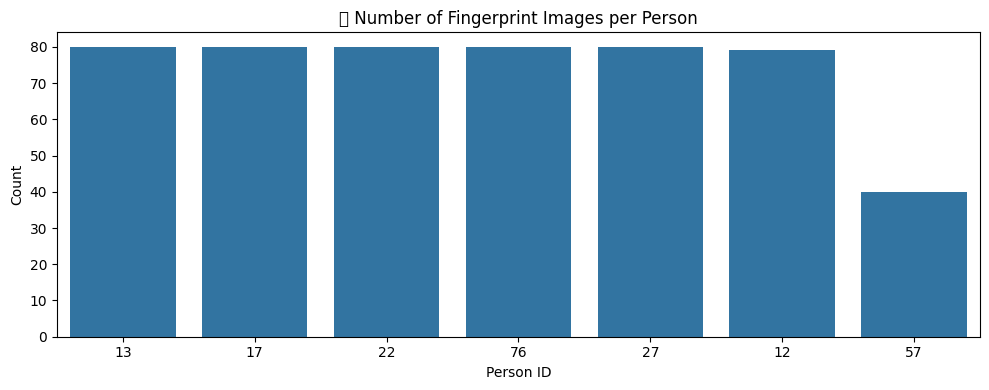

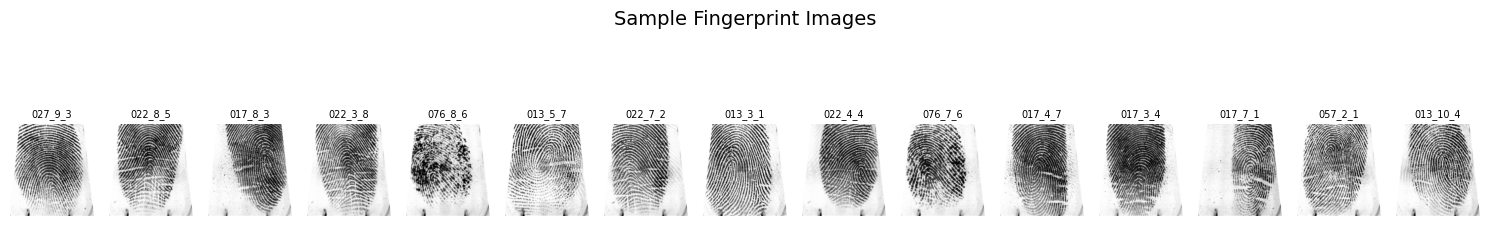

<ipython-input-2-628febee96fc>:94: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-628febee96fc>:94: UserWarning: Glyph 127763 (\N{FIRST QUARTER MOON SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127763 (\N{FIRST QUARTER MOON SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


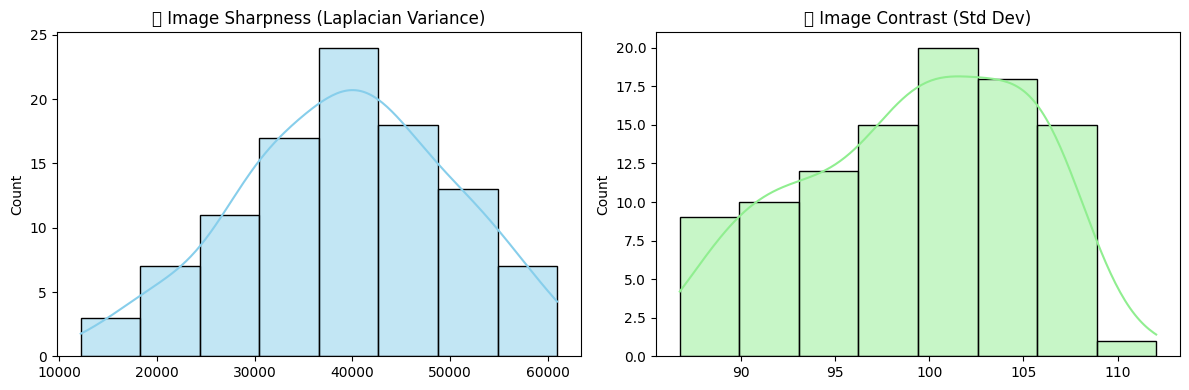

📊 Sharpness - Mean: 39324.51, Std: 10774.35
📊 Contrast  - Mean: 99.28, Std: 5.91


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from glob import glob
from PIL import Image, ImageEnhance
import seaborn as sns

# ✅ CONFIG
DATASET_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/content/Finger samples"
IMAGE_SIZE = (128, 128)

# ✅ SCAN FILES
file_paths = sorted(glob(os.path.join(DATASET_PATH, "*.tif")))
print(f"📁 Total fingerprint images found: {len(file_paths)}")

# ✅ Parse filenames to DataFrame
records = []
for path in file_paths:
    filename = os.path.basename(path)
    try:
        person_id, finger_id, scan_id = filename.replace(".tif", "").split("_")
        records.append((path, int(person_id), int(finger_id), int(scan_id)))
    except:
        print(f"⚠️ Skipped: {filename}")

df = pd.DataFrame(records, columns=["path", "person_id", "finger_id", "scan_id"])
print("✅ Dataset parsed into DataFrame:\n", df.head())

# ✅ Unique stats
num_people = df["person_id"].nunique()
num_fingers = df["finger_id"].nunique()
print(f"🧍 Unique people: {num_people}")
print(f"🖐️ Unique finger IDs: {num_fingers}")

# ✅ Plot: Finger count per person
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="person_id", order=df["person_id"].value_counts().index)
plt.title("🧍 Number of Fingerprint Images per Person")
plt.xlabel("Person ID")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ✅ Visualise sample images
def show_sample_images(df, title="Sample Fingerprint Images", num=15):
    sample_paths = df.sample(num)["path"].values
    plt.figure(figsize=(15, 3))
    for i, path in enumerate(sample_paths):
        img = Image.open(path)
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis("off")
        plt.title(os.path.basename(path).split(".")[0], fontsize=7)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_images(df)

# ✅ Preprocessing function
def preprocess_fingerprint(path):
    img = Image.open(path).convert("L")  # grayscale
    img = img.resize(IMAGE_SIZE)
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(2.0)  # increase contrast
    return np.array(img)

# ✅ Quality metrics
def compute_image_sharpness(image_np):
    laplacian_var = cv2.Laplacian(image_np, cv2.CV_64F).var()
    return laplacian_var

def compute_contrast(image_np):
    return image_np.std()

# ✅ Analyse image quality
sharpness_scores = []
contrast_scores = []

for path in df["path"].sample(100):  # Limit for performance
    img = preprocess_fingerprint(path)
    sharpness_scores.append(compute_image_sharpness(img))
    contrast_scores.append(compute_contrast(img))

# ✅ Visualise sharpness & contrast distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(sharpness_scores, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("🔍 Image Sharpness (Laplacian Variance)")
sns.histplot(contrast_scores, kde=True, ax=axes[1], color="lightgreen")
axes[1].set_title("🌓 Image Contrast (Std Dev)")
plt.tight_layout()
plt.show()

# ✅ Summary stats
print(f"📊 Sharpness - Mean: {np.mean(sharpness_scores):.2f}, Std: {np.std(sharpness_scores):.2f}")
print(f"📊 Contrast  - Mean: {np.mean(contrast_scores):.2f}, Std: {np.std(contrast_scores):.2f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Loss: 0.8197
Epoch 2 Loss: 0.1125
Epoch 3 Loss: 0.0629
Epoch 4 Loss: 0.0581
Epoch 5 Loss: 0.0647
Epoch 6 Loss: 0.0402
Epoch 7 Loss: 0.0412
Epoch 8 Loss: 0.0578
Epoch 9 Loss: 0.0304
Epoch 10 Loss: 0.0209
Epoch 11 Loss: 0.0160
Epoch 12 Loss: 0.0142
Epoch 13 Loss: 0.0136
Epoch 14 Loss: 0.0142
Epoch 15 Loss: 0.0130


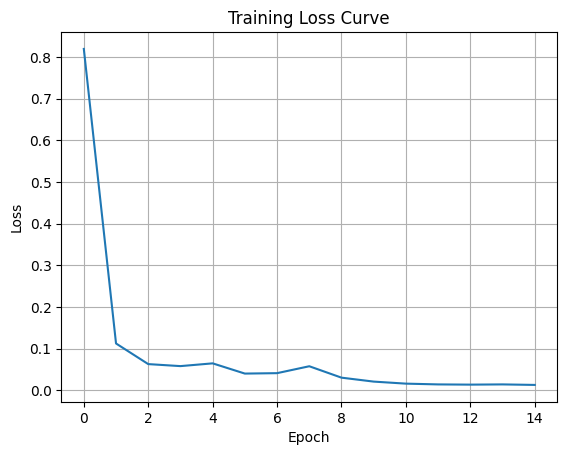

✅ Model saved to: /content/drive/MyDrive/OS&BIOMETRICS/models/fingerprint_resnet18.pt
✅ Label map saved to: /content/drive/MyDrive/OS&BIOMETRICS/models/label_map.pkl

📋 Classification Report:

              precision    recall  f1-score   support

   Person_12       1.00      1.00      1.00        15
   Person_13       1.00      1.00      1.00        20
   Person_17       1.00      1.00      1.00        14
   Person_22       1.00      1.00      1.00        16
   Person_27       1.00      1.00      1.00        17
   Person_76       1.00      1.00      1.00        14

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



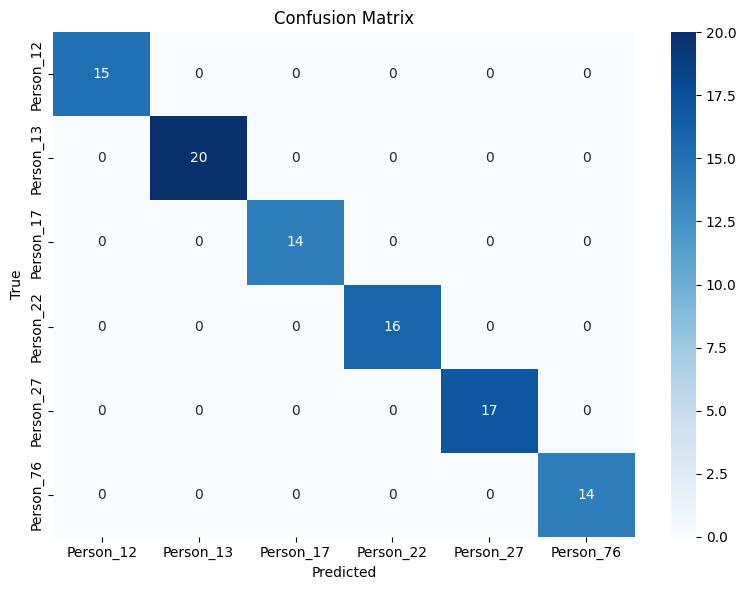

In [ ]:
import os
import cv2
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from glob import glob

# ✅ CONFIG
DATASET_DIR = "/content/drive/MyDrive/OS&BIOMETRICS/content/Finger samples"
SAVE_MODEL_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/models/fingerprint_resnet18.pt"
SAVE_LABEL_MAP_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/models/label_map.pkl"
DROP_PERSON = "57"
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ IMAGE TRANSFORMATIONS
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ✅ LOAD & PARSE
def parse_metadata(filename):
    basename = os.path.basename(filename)
    person, finger, scan = basename.replace(".tif", "").split("_")
    return int(person), int(finger), int(scan)

all_files = [f for f in glob(os.path.join(DATASET_DIR, "*.tif")) if "jim" not in f]
data = []
for path in all_files:
    person_id, finger_id, scan_id = parse_metadata(path)
    if str(person_id) == DROP_PERSON:
        continue
    data.append((path, person_id, finger_id, scan_id))

df = pd.DataFrame(data, columns=["path", "person_id", "finger_id", "scan_id"])
unique_ids = sorted(df["person_id"].unique())
id_to_label = {pid: i for i, pid in enumerate(unique_ids)}
df["label"] = df["person_id"].map(id_to_label)

# ✅ CUSTOM DATASET
class FingerprintDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        label = self.df.loc[idx, "label"]
        image = Image.open(path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label

dataset = FingerprintDataset(df, transform)

# ✅ SPLIT
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

# ✅ MODEL - TRANSFER LEARNING
model = models.resnet18(pretrained=True)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(unique_ids))
model = model.to(device)

# ✅ TRAINING
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

# ✅ PLOT TRAINING LOSS
plt.figure()
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# ✅ SAVE MODEL + LABEL MAP
torch.save(model.state_dict(), SAVE_MODEL_PATH)
with open(SAVE_LABEL_MAP_PATH, "wb") as f:
    pickle.dump(id_to_label, f)
print(f"✅ Model saved to: {SAVE_MODEL_PATH}")
print(f"✅ Label map saved to: {SAVE_LABEL_MAP_PATH}")

# ✅ EVALUATION
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

label_names = [f"Person_{i}" for i in unique_ids]
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_names))

# ✅ CONFUSION MATRIX
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
import torch
import pickle
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import numpy as np
import cv2
from glob import glob

# Paths
MODEL_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/models/fingerprint_resnet18.pt"
LABEL_MAP_PATH = "/content/drive/MyDrive/OS&BIOMETRICS/models/label_map.pkl"

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = torch.nn.Linear(512, 6)  # 6 classes in your saved model (excluding Person_57)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval().to(device)

# Load label map
with open(LABEL_MAP_PATH, "rb") as f:
    label_map = pickle.load(f)
idx_to_person = {v: k for k, v in label_map.items()}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def preprocess_image(path):
    img = Image.open(path).convert("L")
    return transform(img).unsqueeze(0).to(device)


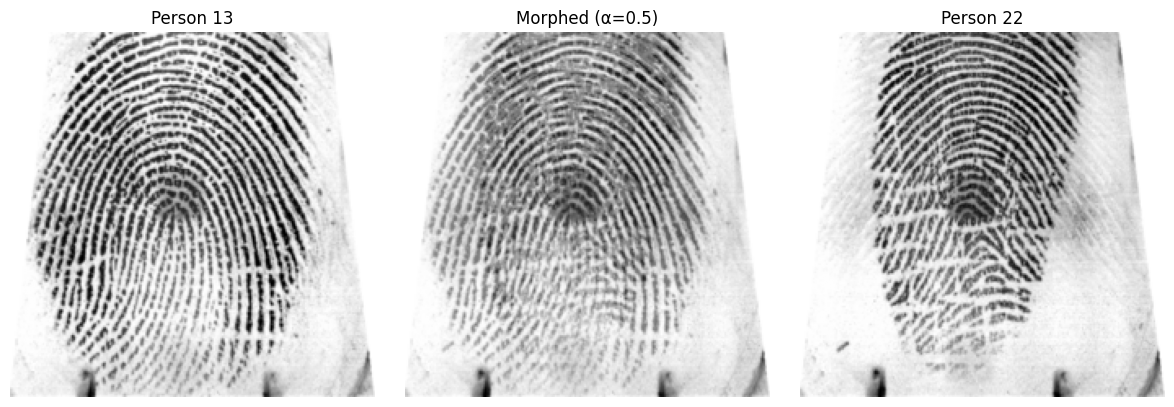

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from glob import glob

def morph_images(path1, path2, alpha=0.5, show=True):
    img1 = Image.open(path1).convert("L").resize((224, 224))
    img2 = Image.open(path2).convert("L").resize((224, 224))

    img1_np = np.array(img1)
    img2_np = np.array(img2)

    blended = cv2.addWeighted(img1_np, alpha, img2_np, 1 - alpha, 0)
    blended_img = Image.fromarray(blended)

    if show:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(img1_np, cmap='gray')
        axs[0].set_title("Person 13")
        axs[0].axis('off')

        axs[1].imshow(blended, cmap='gray')
        axs[1].set_title(f"Morphed (α={alpha})")
        axs[1].axis('off')

        axs[2].imshow(img2_np, cmap='gray')
        axs[2].set_title("Person 22")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

    return blended_img

# Sample image paths
data_dir = "/content/drive/MyDrive/OS&BIOMETRICS/content/Finger samples"
img13 = glob(f"{data_dir}/013_1_*.tif")[0]
img22 = glob(f"{data_dir}/022_1_*.tif")[0]

# Morph and show visually
morphed = morph_images(img13, img22, alpha=0.5)

# Continue with classification
morphed_tensor = transform(morphed).unsqueeze(0).to(device)


🔁 Morph Result (Person 13 + 22): 22
⚠️ Spoof (blur): 12
⚠️ Spoof (distort): 22
⚠️ Spoof (rotate): 76
⚠️ Spoof (lowres): 17


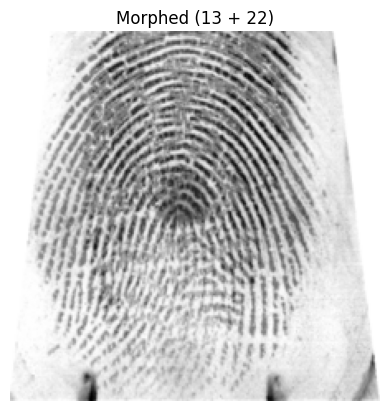

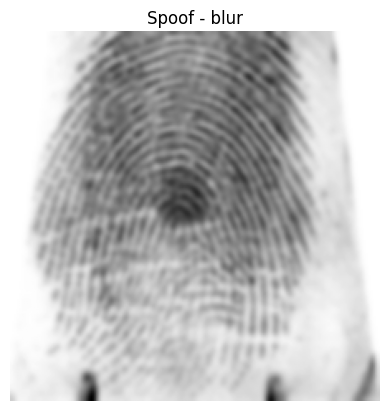

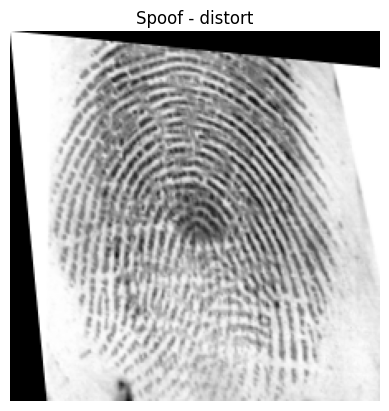

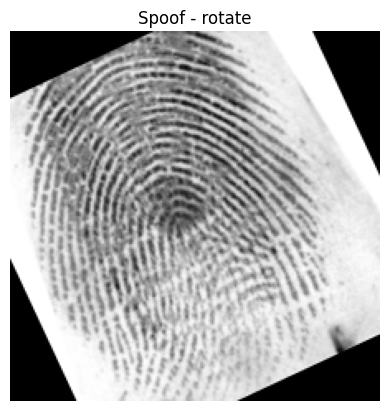

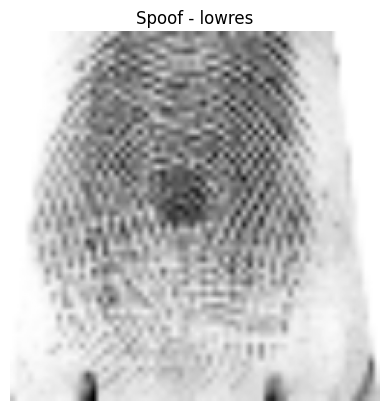

In [ ]:
def apply_spoof_attack(image: Image.Image, attack_type='blur'):
    img_np = np.array(image)

    if attack_type == 'blur':
        img_np = cv2.GaussianBlur(img_np, (9, 9), 0)
    elif attack_type == 'distort':
        rows, cols = img_np.shape
        M = np.float32([[1, 0.1, 0], [0.1, 1, 0]])
        img_np = cv2.warpAffine(img_np, M, (cols, rows))
    elif attack_type == 'rotate':
        M = cv2.getRotationMatrix2D((112, 112), angle=25, scale=1.0)
        img_np = cv2.warpAffine(img_np, M, (224, 224))
    elif attack_type == 'lowres':
        img_np = cv2.resize(img_np, (64, 64))
        img_np = cv2.resize(img_np, (224, 224), interpolation=cv2.INTER_LINEAR)
    else:
        raise ValueError("Unsupported spoof attack")

    return Image.fromarray(img_np)

def classify(img_tensor):
    with torch.no_grad():
        out = model(img_tensor)
        pred = out.argmax(dim=1).item()
    return idx_to_person[pred]

# Evaluate morph
print("🔁 Morph Result (Person 13 + 22):", classify(morphed_tensor))

# Evaluate classic spoofs
for spoof_type in ['blur', 'distort', 'rotate', 'lowres']:
    attacked_img = apply_spoof_attack(morphed, spoof_type)
    attacked_tensor = transform(attacked_img).unsqueeze(0).to(device)
    print(f"⚠️ Spoof ({spoof_type}):", classify(attacked_tensor))

import matplotlib.pyplot as plt

def show_image(title, pil_img):
    plt.imshow(pil_img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

show_image("Morphed (13 + 22)", morphed)
for spoof_type in ['blur', 'distort', 'rotate', 'lowres']:
    spoofed = apply_spoof_attack(morphed, spoof_type)
    show_image(f"Spoof - {spoof_type}", spoofed)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate_spoof(model, spoof_images, id_to_label):
    """
    Evaluates False Accept Rate: how many spoof images were misclassified as real identities.
    """
    model.eval()
    spoof_preds = []

    # Reverse lookup: index → real person_id
    label_to_person = {v: k for k, v in id_to_label.items()}
    real_person_ids = list(id_to_label.keys())

    with torch.no_grad():
        for img in spoof_images:
            img_tensor = transform(img).unsqueeze(0).to(device)
            output = model(img_tensor)
            pred_idx = output.argmax(dim=1).item()
            pred_person = label_to_person[pred_idx]
            spoof_preds.append(pred_person)

    false_accepts = sum([1 for p in spoof_preds if p in real_person_ids])
    total_spoofs = len(spoof_preds)
    far = false_accepts / total_spoofs if total_spoofs else 0

    print(f"🧪 False Accept Rate (FAR): {far:.2%} ({false_accepts}/{total_spoofs} accepted as real identities)")
    return far

def evaluate_accuracy(model, loader, desc="Genuine"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x).argmax(dim=1).cpu()
            y_pred.extend(out.numpy())
            y_true.extend(y.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"✅ {desc} Accuracy: {acc:.2%}")
    return acc

# 1. Clean accuracy
evaluate_accuracy(model, val_loader, desc="Clean")

# 2. Morph attack FAR
morph_imgs = [morph_images(img13, img22, alpha=a, show=False) for a in [0.3, 0.5, 0.7]]
far_morph = evaluate_spoof(model, morph_imgs, id_to_label)

# 3. Blur spoof
from PIL import ImageFilter

def blur_image(pil_img):
    return pil_img.filter(ImageFilter.GaussianBlur(radius=3))

# Example spoof paths (adjust person ID if needed)
data_dir = "/content/drive/MyDrive/OS&BIOMETRICS/content/Finger samples"
spoof_paths = glob(f"{data_dir}/013_1_*.tif")[:3]

# Generate blurred images
blurred_imgs = [blur_image(Image.open(p).convert("L")) for p in spoof_paths]

# Evaluate
far_blur = evaluate_spoof(model, blurred_imgs, id_to_label)


✅ Clean Accuracy: 100.00%
🧪 False Accept Rate (FAR): 100.00% (3/3 accepted as real identities)
🧪 False Accept Rate (FAR): 100.00% (3/3 accepted as real identities)


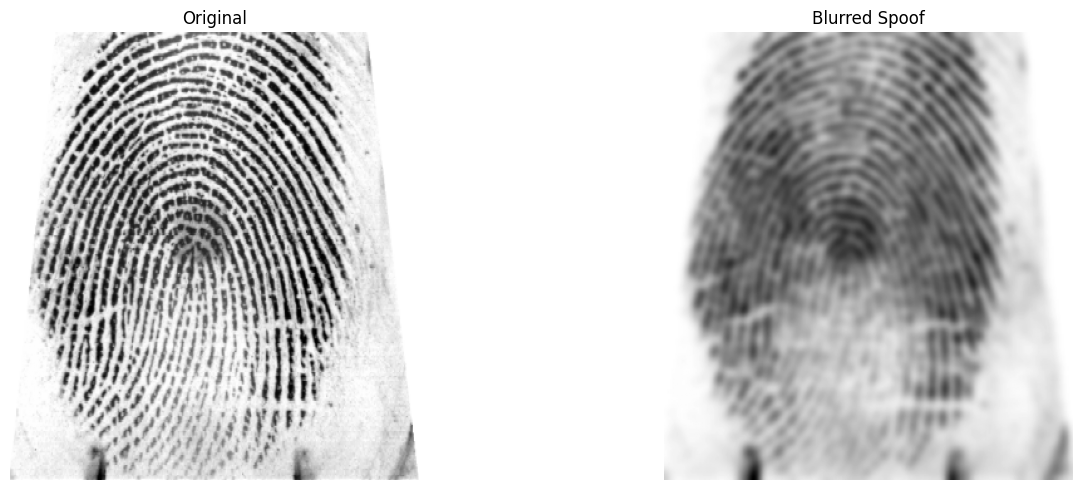

In [ ]:
def show_spoof_comparison(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(title)
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()
show_spoof_comparison([Image.open(spoof_paths[0]).convert("L"), blurred_imgs[0]],
                      ["Original", "Blurred Spoof"])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 Loss: 0.5452
Epoch 2 Loss: 0.1677
Epoch 3 Loss: 0.0270
Epoch 4 Loss: 0.0297
Epoch 5 Loss: 0.0252
Epoch 6 Loss: 0.0334
Epoch 7 Loss: 0.0081
Epoch 8 Loss: 0.0080
Epoch 9 Loss: 0.0220
Epoch 10 Loss: 0.0100


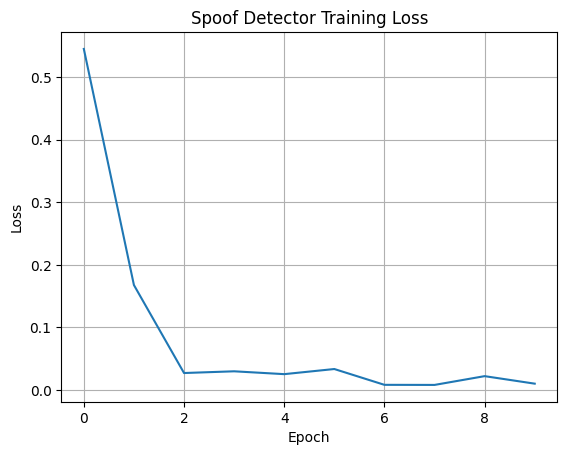


📊 Classification Report:

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00         9
       Spoof       1.00      1.00      1.00         9

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



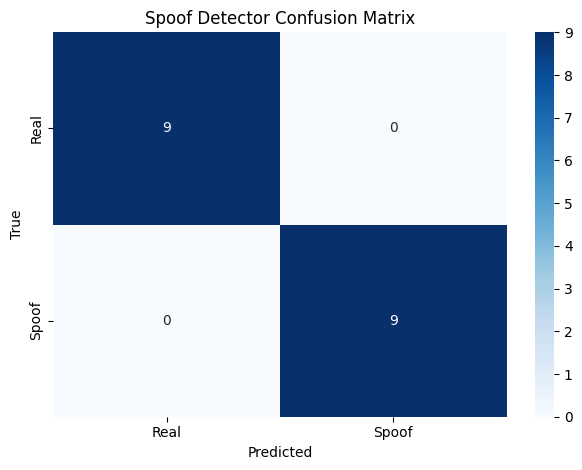

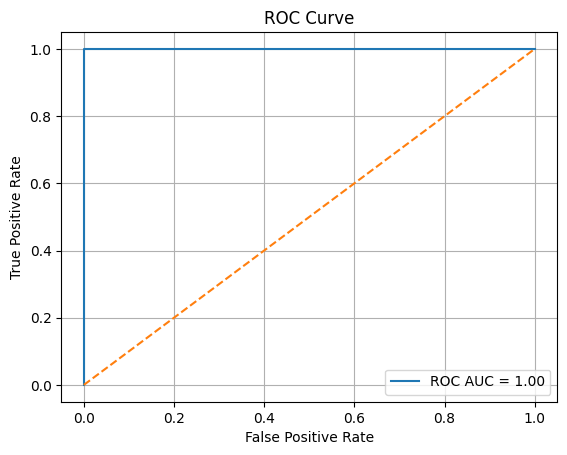

In [ ]:
import os, random
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from glob import glob

# ✅ Configuration
REAL_DIR = "/content/drive/MyDrive/OS&BIOMETRICS/content/Finger samples"
IMG_SIZE = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
EPOCHS = 10

# ✅ Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ✅ Spoof Generation
def morph_images(p1, p2, alpha=0.5):
    i1 = Image.open(p1).convert("L").resize((IMG_SIZE, IMG_SIZE))
    i2 = Image.open(p2).convert("L").resize((IMG_SIZE, IMG_SIZE))
    i1_np, i2_np = np.array(i1), np.array(i2)
    blended = cv2.addWeighted(i1_np, alpha, i2_np, 1 - alpha, 0)
    return Image.fromarray(blended)

def blur_image(p):
    img = Image.open(p).convert("L").resize((IMG_SIZE, IMG_SIZE))
    return img.filter(ImageFilter.GaussianBlur(radius=3))

# ✅ Load paths
paths = [p for p in glob(f"{REAL_DIR}/*.tif") if "jim" not in p and "_57_" not in p]
random.shuffle(paths)
real_paths = paths[:100]

# ✅ Create spoof set
morphs = [morph_images(paths[i], paths[i+1]) for i in range(0, 30, 2)]
blurs = [blur_image(p) for p in paths[30:60]]
spoof_images = morphs + blurs
real_images = [Image.open(p).convert("L").resize((IMG_SIZE, IMG_SIZE)) for p in real_paths[:len(spoof_images)]]

# ✅ Combine & label
X = real_images + spoof_images
y = [0]*len(real_images) + [1]*len(spoof_images)

# ✅ Custom Dataset
class SpoofDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform: img = self.transform(img)
        return img, self.labels[idx]

dataset = SpoofDataset(X, y, transform=transform)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

# ✅ Model
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ✅ Training
losses = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x, y_batch in train_loader:
        x, y_batch = x.to(device), y_batch.to(device)
        out = model(x)
        loss = criterion(out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

# ✅ Loss Plot
plt.plot(losses)
plt.title("Spoof Detector Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ✅ Evaluation
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for x, y_batch in val_loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[:,1]
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_true += y_batch.numpy().tolist()
        y_pred += preds.tolist()
        y_probs += probs.cpu().numpy().tolist()

print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Real", "Spoof"]))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Spoof"], yticklabels=["Real", "Spoof"])
plt.title("Spoof Detector Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
